In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [17]:
batch_size = 8
num_epochs = 150
learning_rate = 0.002
threshold = 0.0011697833045087008
classes = ['abnormal','normal']

cnn_err_rate = []
ae_err_rate = []

In [18]:
abnormal_images = datasets.ImageFolder(
    'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CNN_dataset300\\abnormal',
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

normal_images = datasets.ImageFolder(
    'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CNN_dataset300\\normal',
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

normal_image_list = []
for feature, index in normal_images:
    normal_image_list.append([feature, 1])

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5) 
        self.conv3 = nn.Conv2d(12, 24, 4)  
        self.fc1 = nn.Linear(24 * 25 * 25, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 6 * 110 * 110
        x = self.pool(F.relu(self.conv2(x))) # 12 * 53 * 53
        x = self.pool(F.relu(self.conv3(x))) # 24 * 25 * 25
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                         nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))
        
        self.cnn_layer3 = nn.Sequential(
                                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())
        
        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())

        self.tran_cnn_layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                        nn.Sigmoid())  
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.cnn_layer3(output)        
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        output = self.tran_cnn_layer3(output)

        return output

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device))

## 우리 모델
AE = ConvAutoEncoder()
AE.to(device)
AE.load_state_dict(torch.load('best_model_final.pth'))
ae_criterion = nn.MSELoss()

Using cuda device


In [28]:
import datetime

data_size = [10, 30, 60, 90, 120, 150, 230, 300]

In [29]:
now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

for number, dsize in enumerate(data_size, 0):
    train_loader1 = torch.utils.data.DataLoader(list(abnormal_images)[:dsize] + normal_image_list, batch_size=batch_size, shuffle = True)
    test_loader1 = torch.utils.data.DataLoader(list(abnormal_images)[:dsize] + normal_image_list, batch_size=batch_size, shuffle = False)
    val_loader1 = torch.utils.data.DataLoader(list(abnormal_images)[:dsize], batch_size=batch_size, shuffle = False)
    
    model = CNN()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    file_name = f"data/[{now}]_best_model_final_{number}.pth"
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader1, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            cnn_loss = criterion(outputs, labels)
            cnn_loss.backward()
            optimizer.step()

            # print statistics
            running_loss += cnn_loss.item()
            
        print('[%d, %5d] loss: %.7f' %(epoch, num_epochs, running_loss/len(train_loader1)))

    print('Finished Training')
            
    with torch.no_grad():
        error = 0
        total = 0
        
        for data in test_loader1:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            # calculate outputs by running images through the network 
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            error += (predicted != labels).sum().item()

        cnn_err_rate.append(error/len(test_loader1))
        print('Error rate of test images: %f' % (error / total))


    ae_err = 0
    for data in val_loader1:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        output = AE(images)
        ae_loss = ae_criterion(images, output)

        if ae_loss.item() < threshold:
            ae_err += 1

    ae_err_rate.append(ae_err / len(val_loader1))
    print('AE error rate : %.6f ' % (ae_err / len(val_loader1)))

    torch.save(model.state_dict(), file_name)
    print("save model " + file_name)

    with open(f'[{now}]-error-rate.txt', 'a') as f:
        f.write(f'{dsize} {error/len(test_loader1)} {ae_err / len(val_loader1)}\n')

[0,   150] loss: 0.6992909
[1,   150] loss: 0.6924670
[2,   150] loss: 0.6861661
[3,   150] loss: 0.6801596
[4,   150] loss: 0.6746621
[5,   150] loss: 0.6691960
[6,   150] loss: 0.6653714
[7,   150] loss: 0.6592443
[8,   150] loss: 0.6562589
[9,   150] loss: 0.6520330
[10,   150] loss: 0.6478096
[11,   150] loss: 0.6436886
[12,   150] loss: 0.6367578
[13,   150] loss: 0.6353811
[14,   150] loss: 0.6280999
[15,   150] loss: 0.6237238
[16,   150] loss: 0.6194074
[17,   150] loss: 0.6150735
[18,   150] loss: 0.6150265
[19,   150] loss: 0.6068731
[20,   150] loss: 0.6026786
[21,   150] loss: 0.5984784
[22,   150] loss: 0.5943726
[23,   150] loss: 0.5956199
[24,   150] loss: 0.5862015
[25,   150] loss: 0.5938662
[26,   150] loss: 0.5782421
[27,   150] loss: 0.5802951
[28,   150] loss: 0.5766494
[29,   150] loss: 0.5659848
[30,   150] loss: 0.5616502
[31,   150] loss: 0.5646717
[32,   150] loss: 0.5528957
[33,   150] loss: 0.5566034
[34,   150] loss: 0.5526766
[35,   150] loss: 0.5486040
[3

[139,   150] loss: 0.6336803
[140,   150] loss: 0.6342333
[141,   150] loss: 0.6304709
[142,   150] loss: 0.6285082
[143,   150] loss: 0.6277133
[144,   150] loss: 0.6239430
[145,   150] loss: 0.6248819
[146,   150] loss: 0.6225315
[147,   150] loss: 0.6234559
[148,   150] loss: 0.6169005
[149,   150] loss: 0.6144858
Finished Training
Error rate of test images: 0.375000
AE error rate : 0.000000 
save model data/[2021-12-28_19-43-47]_best_model_final_1.pth
[0,   150] loss: 0.6947756
[1,   150] loss: 0.6940608
[2,   150] loss: 0.6937089
[3,   150] loss: 0.6932389
[4,   150] loss: 0.6928713
[5,   150] loss: 0.6926747
[6,   150] loss: 0.6924439
[7,   150] loss: 0.6919803
[8,   150] loss: 0.6917549
[9,   150] loss: 0.6915015
[10,   150] loss: 0.6912858
[11,   150] loss: 0.6908820
[12,   150] loss: 0.6909426
[13,   150] loss: 0.6909707
[14,   150] loss: 0.6903858
[15,   150] loss: 0.6909289
[16,   150] loss: 0.6901353
[17,   150] loss: 0.6898238
[18,   150] loss: 0.6899411
[19,   150] loss: 

[122,   150] loss: 0.0012735
[123,   150] loss: 0.0012268
[124,   150] loss: 0.0011864
[125,   150] loss: 0.0011393
[126,   150] loss: 0.0011117
[127,   150] loss: 0.0010778
[128,   150] loss: 0.0010650
[129,   150] loss: 0.0010390
[130,   150] loss: 0.0009924
[131,   150] loss: 0.0009737
[132,   150] loss: 0.0009543
[133,   150] loss: 0.0009221
[134,   150] loss: 0.0009119
[135,   150] loss: 0.0008761
[136,   150] loss: 0.0008587
[137,   150] loss: 0.0008368
[138,   150] loss: 0.0008246
[139,   150] loss: 0.0008055
[140,   150] loss: 0.0007781
[141,   150] loss: 0.0007955
[142,   150] loss: 0.0007511
[143,   150] loss: 0.0007552
[144,   150] loss: 0.0007161
[145,   150] loss: 0.0007248
[146,   150] loss: 0.0006889
[147,   150] loss: 0.0006712
[148,   150] loss: 0.0006630
[149,   150] loss: 0.0006518
Finished Training
Error rate of test images: 0.000000
AE error rate : 0.000000 
save model data/[2021-12-28_19-43-47]_best_model_final_3.pth
[0,   150] loss: 0.7274916
[1,   150] loss: 0.7

[105,   150] loss: 0.4104472
[106,   150] loss: 0.4041451
[107,   150] loss: 0.3998193
[108,   150] loss: 0.3954746
[109,   150] loss: 0.3911270
[110,   150] loss: 0.3828319
[111,   150] loss: 0.3762648
[112,   150] loss: 0.3694248
[113,   150] loss: 0.3628472
[114,   150] loss: 0.3546759
[115,   150] loss: 0.3418594
[116,   150] loss: 0.3363437
[117,   150] loss: 0.3236106
[118,   150] loss: 0.3165368
[119,   150] loss: 0.2928149
[120,   150] loss: 0.2920338
[121,   150] loss: 0.2698290
[122,   150] loss: 0.2522808
[123,   150] loss: 0.2330635
[124,   150] loss: 0.2240776
[125,   150] loss: 0.2104395
[126,   150] loss: 0.2005908
[127,   150] loss: 0.2265922
[128,   150] loss: 0.1562081
[129,   150] loss: 0.1586806
[130,   150] loss: 0.1456346
[131,   150] loss: 0.1732419
[132,   150] loss: 0.1919148
[133,   150] loss: 0.1292157
[134,   150] loss: 0.1010959
[135,   150] loss: 0.2055750
[136,   150] loss: 0.1267517
[137,   150] loss: 0.1254617
[138,   150] loss: 0.0917066
[139,   150] l

[86,   150] loss: 0.0007110
[87,   150] loss: 0.0006721
[88,   150] loss: 0.0006633
[89,   150] loss: 0.0006234
[90,   150] loss: 0.0006123
[91,   150] loss: 0.0005874
[92,   150] loss: 0.0005646
[93,   150] loss: 0.0005477
[94,   150] loss: 0.0005302
[95,   150] loss: 0.0005124
[96,   150] loss: 0.0004927
[97,   150] loss: 0.0004813
[98,   150] loss: 0.0004642
[99,   150] loss: 0.0004547
[100,   150] loss: 0.0004402
[101,   150] loss: 0.0004277
[102,   150] loss: 0.0004138
[103,   150] loss: 0.0004061
[104,   150] loss: 0.0003965
[105,   150] loss: 0.0003860
[106,   150] loss: 0.0003725
[107,   150] loss: 0.0003647
[108,   150] loss: 0.0003575
[109,   150] loss: 0.0003477
[110,   150] loss: 0.0003418
[111,   150] loss: 0.0003330
[112,   150] loss: 0.0003262
[113,   150] loss: 0.0003163
[114,   150] loss: 0.0003147
[115,   150] loss: 0.0003087
[116,   150] loss: 0.0002974
[117,   150] loss: 0.0002919
[118,   150] loss: 0.0002893
[119,   150] loss: 0.0002793
[120,   150] loss: 0.0002774

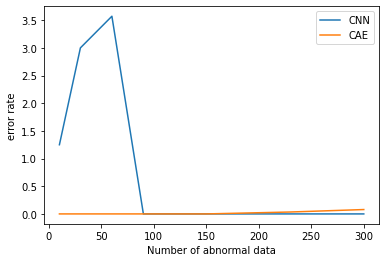

In [31]:
with open(f'[{now}]-error-rate.txt', 'r') as f:
    data = f.readlines()
    
    num_abnormal = list()
    cnn_err_rate = list()
    ae_err_rate = list()
    for index in data:
        num, cnn, ae = tuple(map(float, index.split()))
        num_abnormal.append(num)
        cnn_err_rate.append(cnn)
        ae_err_rate.append(ae)
        
    plt.plot(num_abnormal, cnn_err_rate, label = 'CNN')
    plt.plot(num_abnormal, ae_err_rate, label = 'CAE')
    plt.xlabel('Number of abnormal data')
    plt.ylabel('error rate')
    plt.legend()
    plt.show()